In [1]:
import torch
import torch.nn as nn
from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from torchsummary import summary
import scipy as sp

epochs = 30
n_tasks = 3
L = 0
gamma0 = 20
widths = [64,128,256,512,1024]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(123)
batch = 500

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param =='ntk':
                    self.gamma = gam
                    self.in_scale = 784**0.5
                    self.out_scale = self.w**0.5*self.gamma
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                     self.in_scale = 784**0.5
                     self.out_scale = self.w**0.5*self.gamma
                elif param == 'sp':
                     self.gamma = 1
                     self.in_scale = 1
                     self.out_scale = 1

                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.fc2 = nn.Linear(self.w, 10, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                h1 = self.fc1(x)/self.in_scale
                h1act = self.relu(h1)
                h2 = self.fc2(h1act)/self.out_scale

                return h2
            
@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()

def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')
#data = data[data['label'].isin([0, 1])]
#test = test[test['label'].isin([0, 1])]
X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255


Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(10, device=device)[Y_temp]


Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(10, device=device)[Y_temp]

tasks = [X]
tasks_test = [X_test]

for _ in range(n_tasks):
        perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=perm)).to(device))


def top_eigen(model, loss, X, Y, prt=False):

            hess_comp = hessian(model, loss, (X,Y) )
            top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
                
            return top_eigenvalues[-1] , top_eigenvector

def overlap(model, inputs, targets):
    
    gradients = torch.cat([param.grad.view(-1) for param in model.parameters()])
    params = torch.cat([param.data.view(-1) for param in model.parameters()])

    norm = torch.norm(params)

    def loss_fn(params):
        idx = 0
        layers = []
        for param in model.parameters():
            param_numel = param.numel()
            layers.append(params[idx:idx + param_numel].view_as(param))
            idx += param_numel
        relu = nn.ReLU()
        outputs = relu(inputs@layers[0].T) @ layers[1].T
        return MSE(outputs, targets)

    hvp = torch.autograd.functional.hvp(loss_fn, params, gradients)[1]
    return (torch.dot(hvp,gradients)/(torch.norm(hvp) * torch.norm(gradients))).item(), norm.item()

In [2]:
save_out = False

for regime in ['ntk','mup']:
    for N in widths:
        
        loss_hist = []
        lam = []
        acc = []
        all = []
        norm = []
        res1 = []
        res2 = []
        
        mlp = MLP(N,L,regime, gamma0)
        lrs = {'sp':1,'ntk':1,'mup': mlp.gamma**2}
        lr = lrs.get(regime)

        if regime == 'ntk' or regime == 'mup':
            mlp = mlp.apply(init_weights)
            
        #summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr= lr )
        eos = 2/lr
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):
                print(f'Training on task number:{t+1}, width:{N}, regime:{regime}')
                for epoch in range(epochs):

                        running_loss = 0.0
                        for i in range(len(Xt)//batch):

                            # Batch of training 
                            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

                            ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

                            lt = []
                            for s in range(t+1):
                                sharp, eigen = top_eigen(mlp, MSE, tasks[s][ixc], Y[ixc])
                                lt.append(sharp)
                            lam.append(lt)    

                            optimizer.zero_grad()

                            out = mlp(Xt[ix])
                            loss = MSE(out, Y[ix])
                            
                            loss.backward()
                            running_loss += loss.item()

                            over, no = overlap(mlp, X[ix], Y[ix])

                            all.append(over)
                            norm.append(no)
                            
                            optimizer.step()
                            loss_hist.append(loss.item())

                            #print(f'task {t} : (epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f}')

                print(f'Finished Training task{t+1}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.argmax(mlp(tasks_test[s]), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item() )  
                acc.append(acct) 
                
        if save_out:        
            with open(f'data/lamda{N}_{regime}_{2/eos}_{n_tasks+1}.txt', 'w') as file:
            
                for lst in lam:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'data/acc{N}_{regime}_{2/eos}_{n_tasks+1}.txt', 'w') as file:

                for lst in acc:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'data/overlap{N}_{regime}_{2/eos}_{n_tasks+1}.txt', 'w') as file:

                for a in all:
                    file.write(str(a) + ' ')
        
            with open(f'data/norm{N}_{regime}_{2/eos}_{n_tasks+1}.txt', 'w') as file:

                for n in norm:
                    file.write(str(n) + ' ')

Training on task number:1, width:64, regime:ntk


/opt/homebrew/lib/python3.11/site-packages/torch/autograd/graph.py:690: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1183.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [19]:
epochs = 30
n_tasks = 5
L = 0
gamma0 = 1
widths = [64,128,256,512,1024]

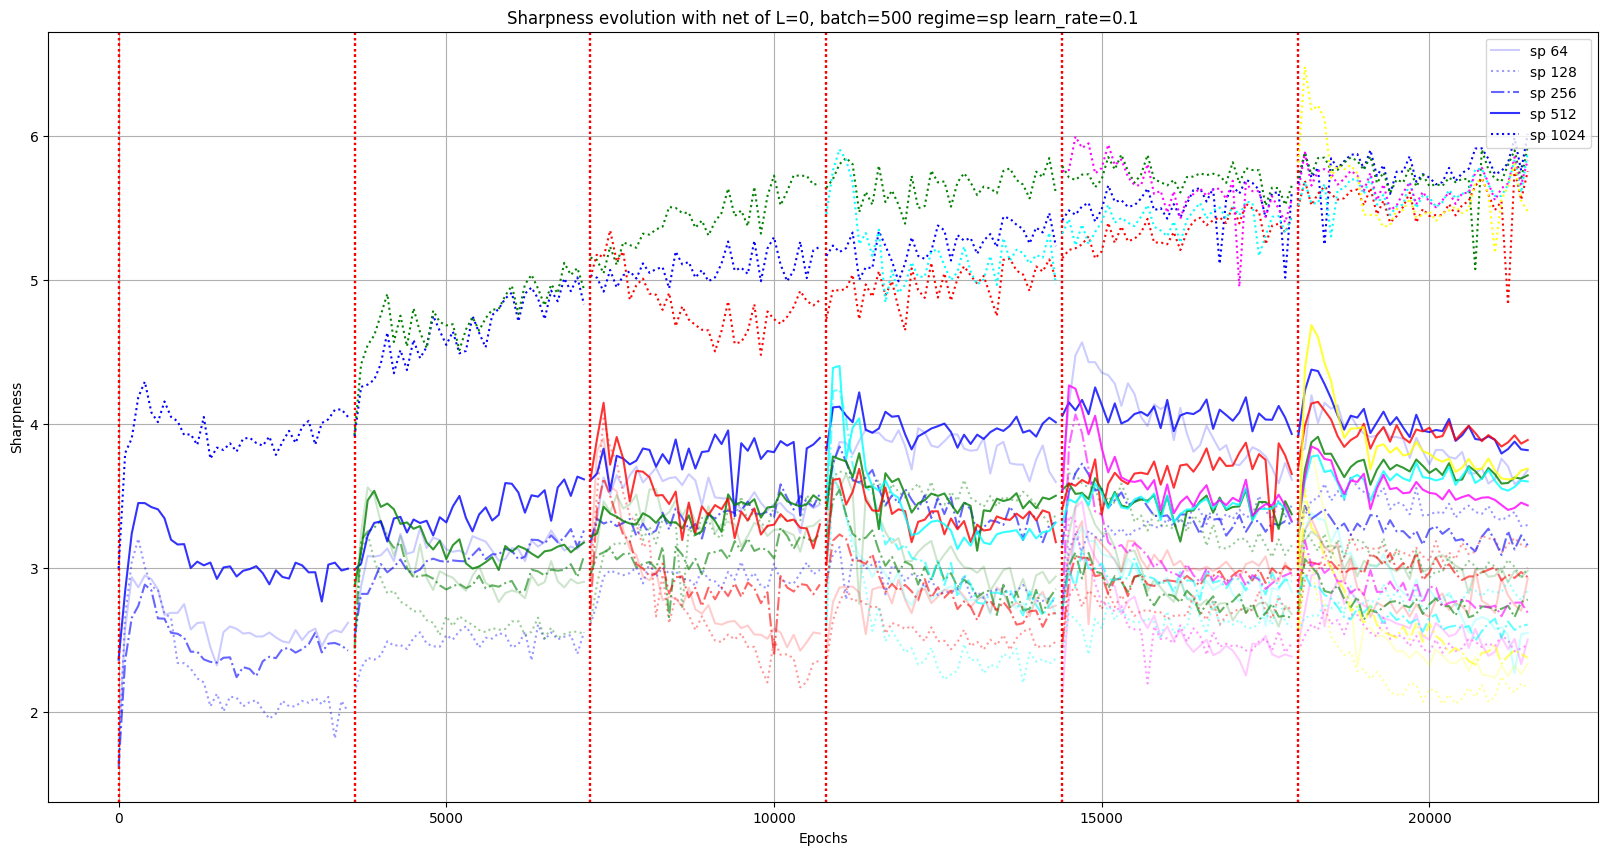

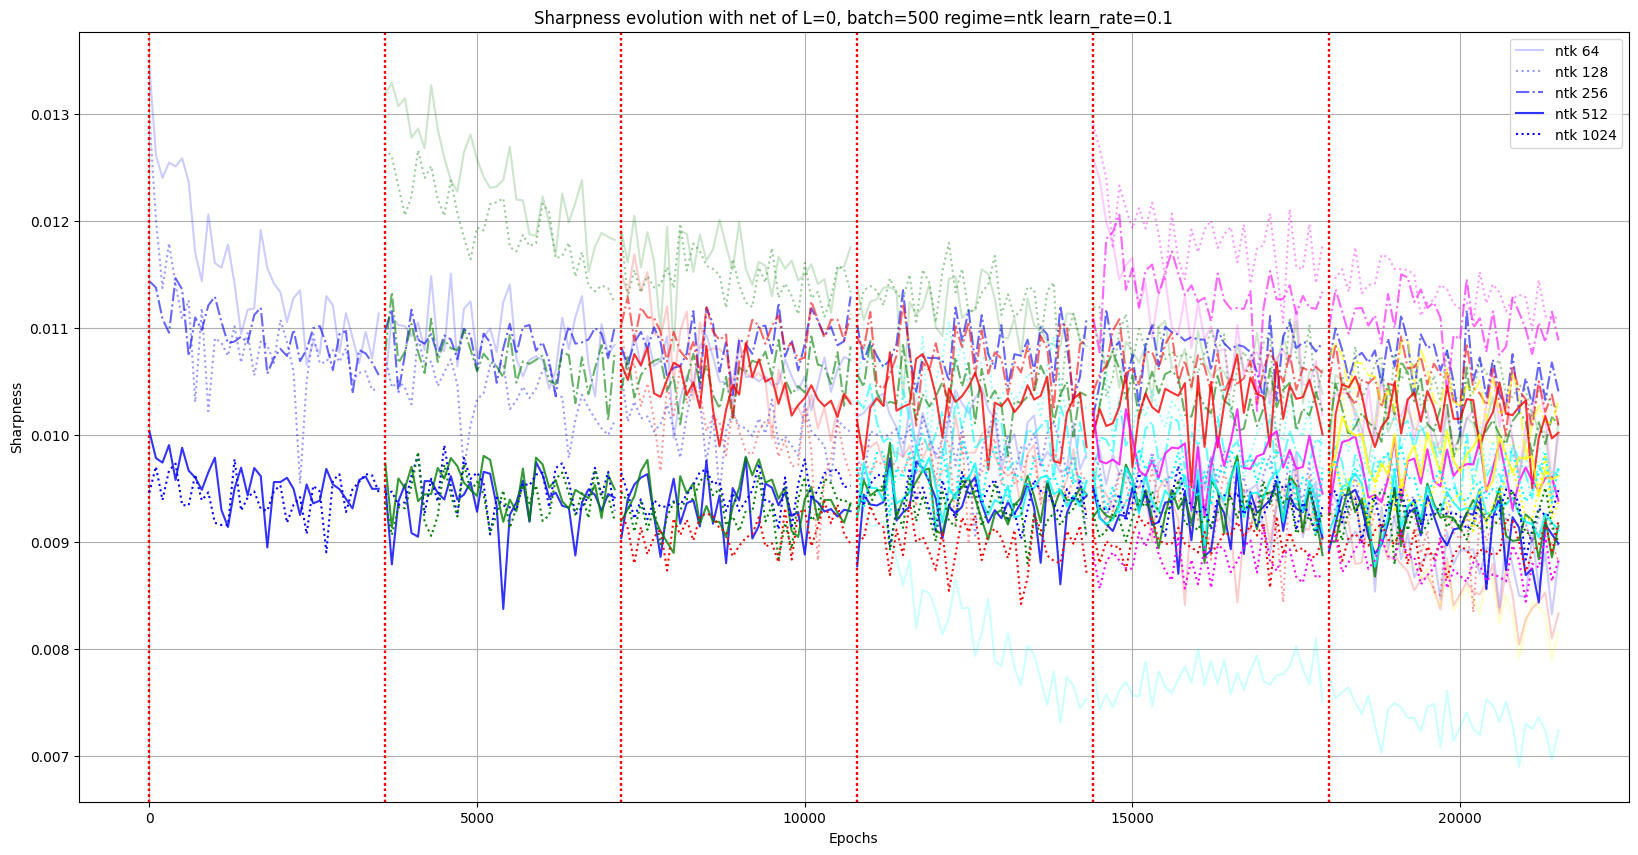

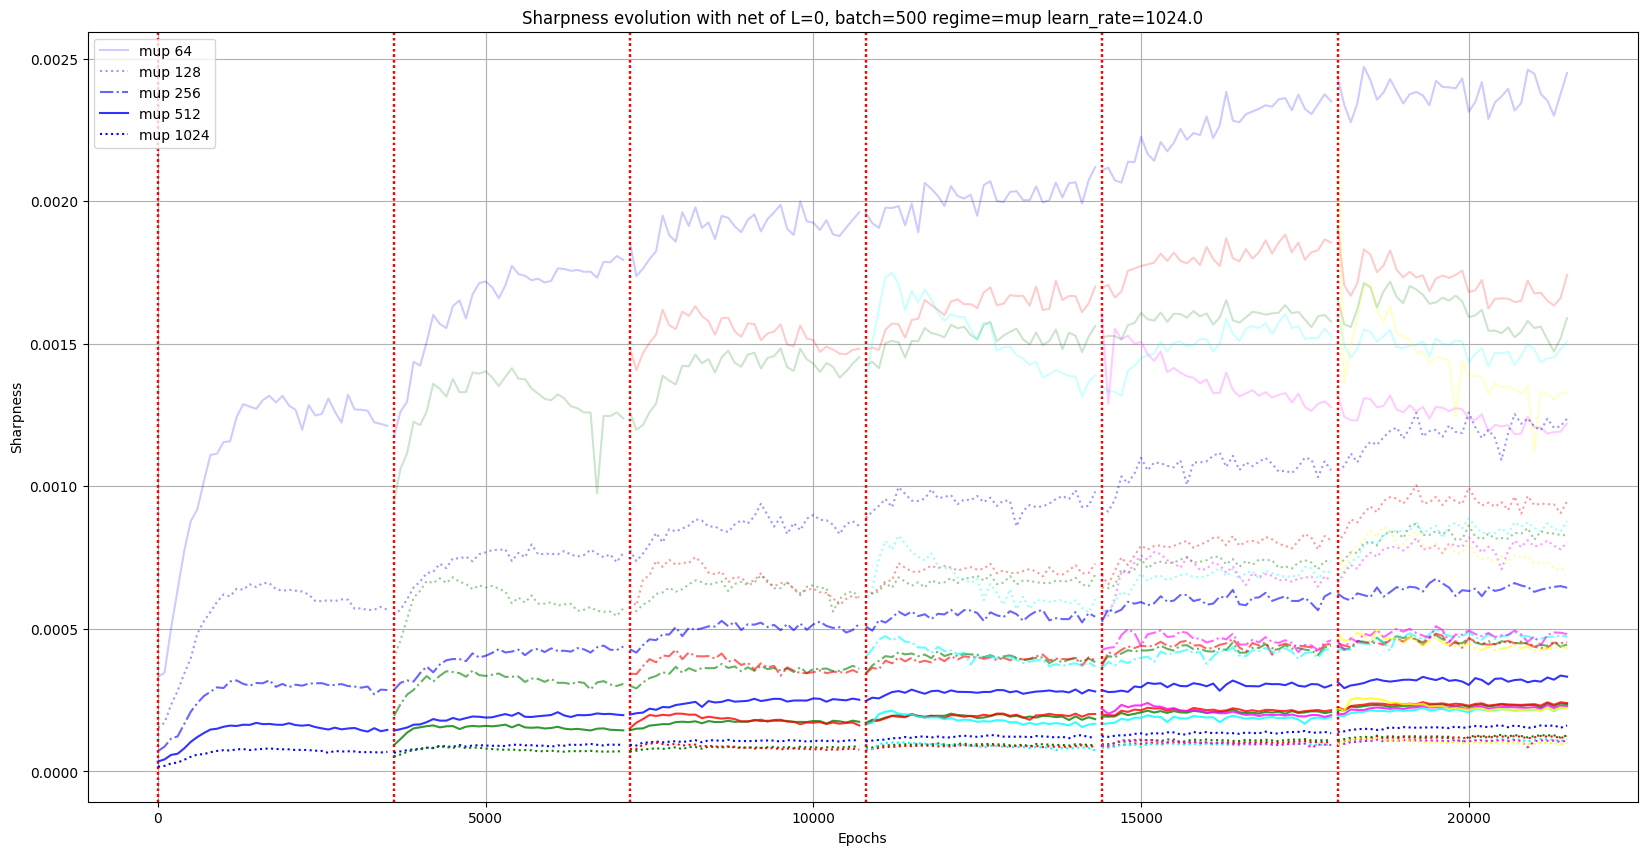

In [20]:
def SHARP(regime):
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    plt.figure(figsize=(20,10))
    #plt.title(f'Sharpness evolution with net of L={L}, batch={batch} regime={regime}')
    
    for N,al,ls in zip(widths,[0.2,0.4,0.6,0.8,0.99],['-',':','-.','-',':']):
        lrs = {'sp':0.1,'ntk':0.1,'mup':N*gamma0**2*1.0}
        lr = lrs.get(regime)

        lam_rec = []
        
        plt.title(f'Sharpness evolution with net of L={L}, batch={batch} regime={regime} learn_rate={lr}')

        sourcefile = f'/Users/alessandrobreccia/Desktop/THESIS/data/VM/lamda{N}_{regime}_{lr}_{n_tasks+1}.txt'

        with open(sourcefile, 'r') as file:
            lines = file.readlines()

        for line in lines:
            lst = list(map(float, line.strip(',').split()))
            lam_rec.append(lst)
                
        a = np.array(lam_rec).T

        sh1 = a[0:T]
        sh2 = a[T:3*T]
        sh3 = a[3*T:6*T]
        sh4 = a[6*T:10*T]
        sh5 = a[10*T:15*T]
        sh6 = a[15*T:21*T]
    
        for i,sh in enumerate([sh1,sh2,sh3,sh4,sh5,sh6]):
            plt.axvline(i*T, color='r', linestyle='dotted')
            for j,row in enumerate(sh.reshape(T,i+1).T):
                if i == 0:
                    plt.plot(np.arange(i*T,(i+1)*T,100), row[::100], color=colors[j], label =f'{regime} {N}', alpha=al, linestyle=ls)
                else:
                    plt.plot(np.arange(i*T,(i+1)*T,100), row[::100], color=colors[j], alpha=al, linestyle=ls)

    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    #if regime != 'ntk': 
     #   plt.axhline(2/lr, color='black', linestyle='dotted')
    plt.legend()
    plt.grid()
    plt.show()

SHARP('sp')
SHARP('ntk')
SHARP('mup')

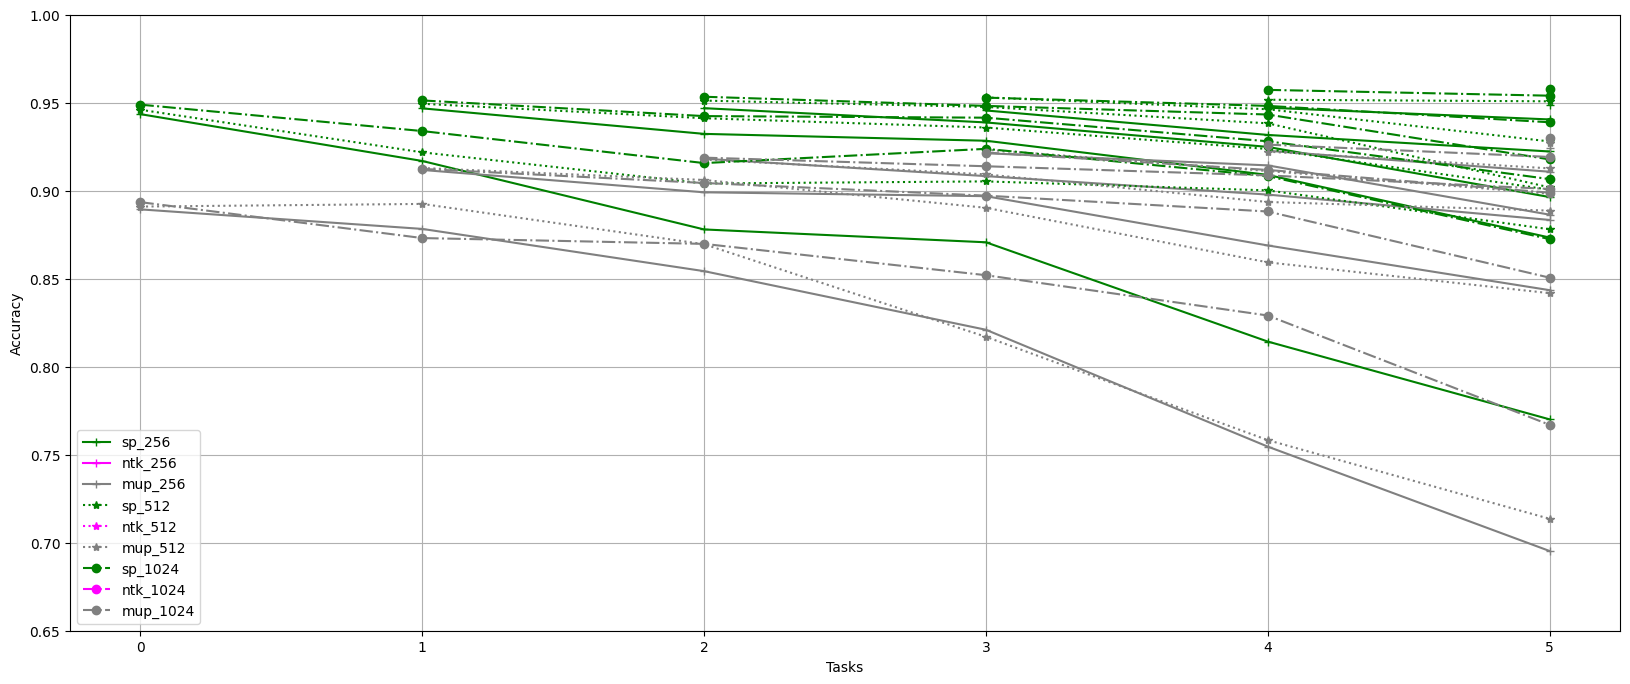

In [27]:
def ACC():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    fig = plt.figure(figsize=(20,8))

    for N,mar,ls in zip(widths[2:],['+','*','o','*','o'],['-',':','-.','-',':']):
        for regime,c,lr in zip(['sp','ntk','mup'],[1,4,7],[0.1,0.1,N*gamma0**2*1.0]):

            acc_rec = []
            sourcefile = f'/Users/alessandrobreccia/Desktop/THESIS/data/VM/acc{N}_{regime}_{lr}_{n_tasks+1}.txt'
            with open(sourcefile, 'r') as file:
                lines = file.readlines()

            for line in lines:
                lst = list(map(float, line.strip(',').split()))
                acc_rec.append(lst)
                    
            a = np.array(acc_rec).T

            accs = [a[:1],a[1:3],a[3:6],a[6:10],a[10:15],a[15:21]]

            for i in range(n_tasks):
                if i == 0:
                    plt.plot(range(i,n_tasks+1),[a[i] for a in accs[i:]], color=colors[c], label=f'{regime}_{N}', marker=mar, linestyle=ls)
                else: 
                    plt.plot(range(i,n_tasks+1),[a[i] for a in accs[i:]], color=colors[c], marker=mar, linestyle=ls)
                    
            plt.plot(n_tasks,accs[-1][-1], color=colors[c], marker=mar )
        
    plt.ylabel('Accuracy')
    plt.xlabel('Tasks')
    plt.legend()
    plt.grid()
    plt.ylim(0.65,1)
    plt.show()

ACC()

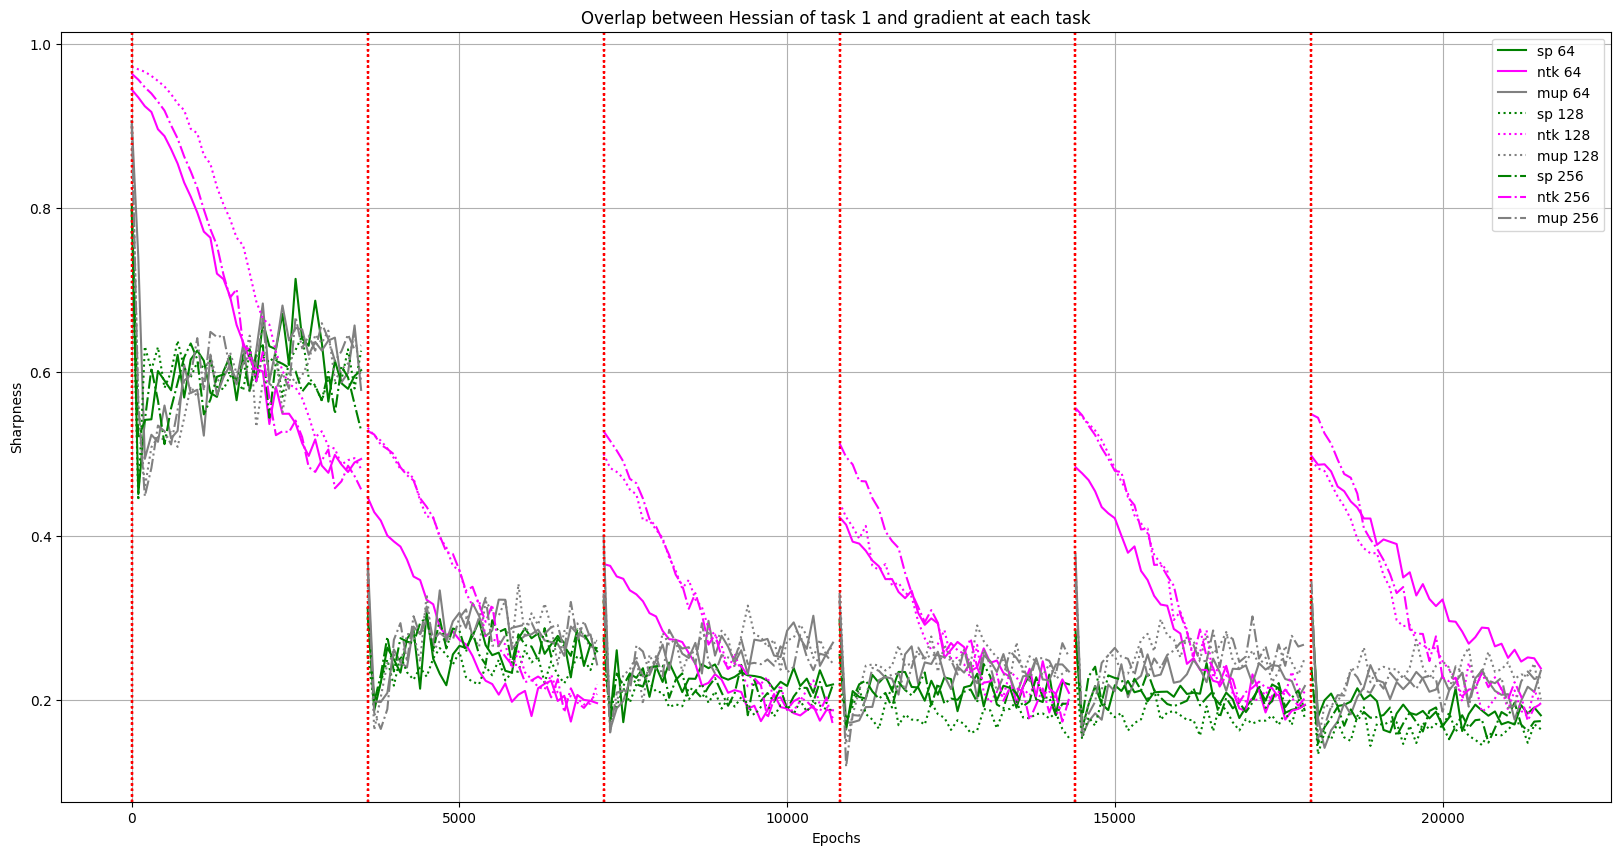

In [29]:
def OVERLAP():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    
    plt.figure(figsize=(20,10))
    plt.title(f'Overlap between Hessian of task 1 and gradient at each task')
    
    for N,ls in zip(widths,['-',':','-.']):
        for regime,c,lr in zip(['sp','ntk','mup'],[1,4,7],[0.1,0.1,N*gamma0**2*1.0]):

            over_rec = []
            sourcefile = f'/Users/alessandrobreccia/Desktop/THESIS/data/VM/overlap{N}_{regime}_{lr}_{n_tasks+1}.txt'
            with open(sourcefile, 'r') as file:
                lines = file.readlines()

            for line in lines:
                lst = list(map(float, line.strip(',').split()))
                over_rec.append(lst)

            a = np.array(over_rec).T

            sh1 = a[0:T]
            sh2 = a[T:2*T]
            sh3 = a[2*T:3*T]
            sh4 = a[3*T:4*T]
            sh5 = a[4*T:5*T]
            sh6 = a[5*T:6*T]

            for i,sh in enumerate([sh1,sh2,sh3,sh4,sh5,sh6]):
                plt.axvline(i*T, color='r', linestyle='dotted')
                for j,row in enumerate(sh.T):
                    if i==0:
                        plt.plot(np.arange(i*T,(i+1)*T-5,100), np.convolve(row, np.ones(6)/6, mode='valid')[::100], color=colors[c], label=f'{regime} {N}', linestyle=ls)
                    else:
                        plt.plot(np.arange(i*T,(i+1)*T-5,100), np.convolve(row, np.ones(6)/6, mode='valid')[::100], color=colors[c], linestyle=ls)

    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    plt.show()


OVERLAP()

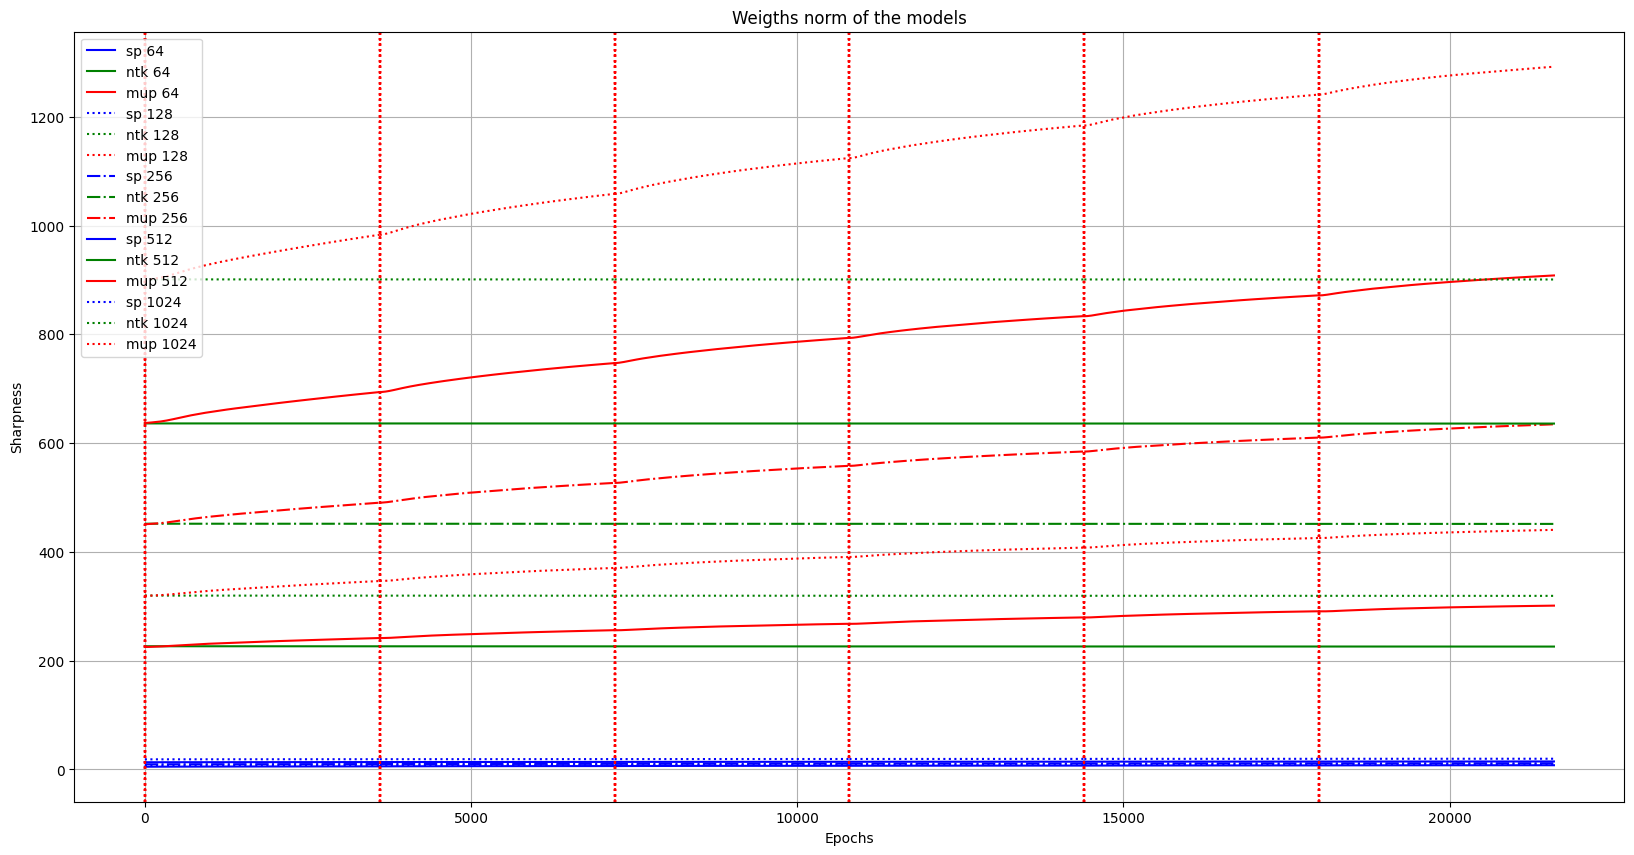

In [32]:
def NORM():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    
    plt.figure(figsize=(20,10))
    plt.title(f'Weigths norm of the models')
    
    for N,ls in zip(widths,['-',':','-.','-',':']):
        for regime,c,lr in zip(['sp','ntk','mup'],[0,1,2],[0.1,0.1,N*gamma0**2*1.0]):

            norm_rec = []
            sourcefile = f'/Users/alessandrobreccia/Desktop/THESIS/data/VM/norm{N}_{regime}_{lr}_{n_tasks+1}.txt'
            with open(sourcefile, 'r') as file:
                lines = file.readlines()

            for line in lines:
                lst = list(map(float, line.strip(',').split()))
                norm_rec.append(lst)

            a = np.array(norm_rec).T

            sh1 = a[0:T]
            sh2 = a[T:2*T]
            sh3 = a[2*T:3*T]
            sh4 = a[3*T:4*T]
            sh5 = a[4*T:5*T]
            sh6 = a[5*T:6*T]

            for i,sh in enumerate([sh1,sh2,sh3,sh4,sh5,sh6]):
                plt.axvline(i*T, color='r', linestyle='dotted')
                for j,row in enumerate(sh.T):
                    if i == 0:
                        plt.plot(np.arange(i*T,(i+1)*T,1), row, color=colors[c], label=f'{regime} {N}', linestyle=ls)
                    else:
                        plt.plot(np.arange(i*T,(i+1)*T,1), row, color=colors[c], linestyle=ls)


    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()
    plt.show()


NORM()